In [16]:
from IPython.core.debugger import set_trace

import os
import sys
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder    #tranforma variables categoricas a numericas
from sklearn.preprocessing import StandardScaler  # Escala los datos
from sklearn.ensemble import IsolationForest      # Algoritmo de recorte
from sklearn.decomposition import PCA             # Reduccion de dimensionalidad
from sklearn.model_selection import train_test_split  # divide de manera aleatoria en sub conjuntos de datos de prueba y entrenamiento
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import confusion_matrix      # genera la matriz de confusion
from sklearn.preprocessing import LabelEncoder    #tranforma variables categoricas a numericas
from sklearn.preprocessing import StandardScaler  # Escala los datos
from numpy import linalg as LA
from sklearn.ensemble import IsolationForest
import pickle

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sklearn.neighbors import LocalOutlierFactor

In [17]:
path = 'C:\\Users\\josrenca\\Desktop\\Universidad\\Datos PI - ARI\\'
archivo = 'cleanedVariables-standarized-respuestaBinaria.pkl'
rutaArchivo = path + archivo
df = pd.read_pickle(rutaArchivo)

In [18]:
df.shape

(3027853, 36)

In [19]:
df.columns

Index(['Amenity', 'Astronomical_Twilight', 'Bump', 'City', 'Civil_Twilight',
       'County', 'Crossing', 'Give_Way', 'Hour', 'Junction',
       'Nautical_Twilight', 'No_Exit', 'Railway', 'Roundabout', 'Severity',
       'Start_Lat', 'Start_Lng', 'State', 'Station', 'Stop', 'Street',
       'Sunrise_Sunset', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Weather_Condition', 'Wind_Direction', 'dayOfWeek', 'month',
       'newSeverity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Description'],
      dtype='object')

In [20]:
newSeverity =  df['newSeverity']
Severity = df['Severity']

In [21]:
df = df[df.columns.difference(['newSeverity','Severity'])]

In [22]:
df.columns

Index(['Amenity', 'Astronomical_Twilight', 'Bump', 'City', 'Civil_Twilight',
       'County', 'Crossing', 'Description', 'Give_Way', 'Hour', 'Humidity(%)',
       'Junction', 'Nautical_Twilight', 'No_Exit', 'Pressure(in)', 'Railway',
       'Roundabout', 'Start_Lat', 'Start_Lng', 'State', 'Station', 'Stop',
       'Street', 'Sunrise_Sunset', 'Temperature(F)', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Visibility(mi)', 'Weather_Condition',
       'Wind_Direction', 'Wind_Speed(mph)', 'dayOfWeek', 'month'],
      dtype='object')

In [23]:
df.shape

(3027853, 34)

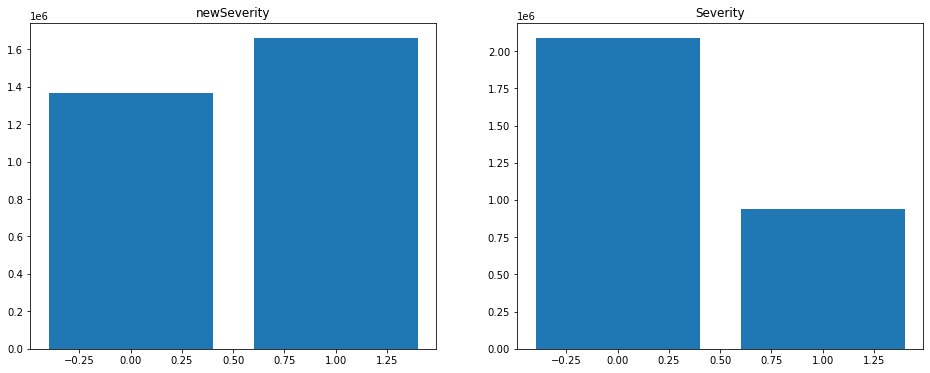

In [24]:
x = newSeverity.value_counts().index
y = newSeverity.value_counts().values

f = plt.figure(1, figsize=(16, 6))
ax1 = f.add_subplot(1, 2, 1)
ax1.title.set_text("newSeverity")
_ = ax1.bar(x, y)

x = Severity.value_counts().index
y = Severity.value_counts().values

f = plt.figure(1, figsize=(16, 6))
ax2 = f.add_subplot(1, 2, 2)
ax2.title.set_text("Severity")
_ = ax2.bar(x, y)

In [27]:
numericData_lst = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

In [30]:
import time

def recorteModel(dfOriginal, variableObjetivo, contInicial, rango, numModelos):
    
    print("Preparando los datos...")
    
    dfOriginal = pd.concat([dfOriginal.reset_index(drop=True),variableObjetivo.reset_index(drop=True)], join="outer",axis=1)
    dfCopy = dfOriginal.copy()[dfOriginal.columns.difference(['Description'])].reset_index(drop=True)
    numsCond = []
    tiemposRecorte = []
    nombreVariableObj = variableObjetivo.name
    contaminacionVec = []
    
    numCondActual = LA.cond(dfCopy[numericData_lst].cov().to_numpy())
    
    tiemposRecorte.append(0)
    numsCond.append(numCondActual)
    contaminacionVec.append(0)
    
    print("Dimensiones matriz Original: " + str(dfOriginal.shape))
    print("Dimensiones matriz Copia: " + str(dfCopy.shape))
    
    contaminacion = contInicial
    for i in range(1,numModelos+1):
        
        start_time = time.time()
        
        print("\n<<<<<<<<<<<<<<<<<<<<<<<< Modelo: " + str(i) + " >>>>>>>>>>>>>>>>>>>>>>>>")
        print("Contaminacion: " + str(contaminacion))
        
        model = LocalOutlierFactor(contamination=contaminacion, novelty=True)
        model.fit(dfCopy.values)
        
        archivoModelo = "cleanedModel-LOF-" + str(contaminacion) + "p-" + nombreVariableObj +".pkl"
        rutaArchivo = path + "ModeloRecorteLOFBinaria\\" + archivoModelo  
        modelfile = open(rutaArchivo, "wb")
        pickle.dump(model, modelfile)
        modelfile.close()
        
        dfOriginal["iforest"] = pd.Series(model.predict(dfCopy.values))
        print(dfOriginal["iforest"].value_counts())
        dfCopy = dfOriginal[dfOriginal["iforest"] != -1]
        dfOriginal = dfOriginal.drop('iforest', axis=1)
        dfCopy = dfCopy.drop('iforest', axis=1)
        
        archivoDatos = "cleanedData-LOF-" + str(contaminacion) + "p-" + nombreVariableObj +".pkl"
        rutaArchivo = path + "DatosRecorteLOFBinaria\\" + archivoDatos  
        dfCopy.reset_index(drop=True).to_pickle(rutaArchivo)
        
        numCondActual = LA.cond(dfCopy[numericData_lst].cov().to_numpy())
        tiempoEjecucion = time.time() - start_time
        
        print("Nombre Modelo: " + archivoModelo)
        print("Nombre Dataset Limpio: " + archivoDatos + " | Dimensiones : " + str(dfCopy.shape))
        print("Numero condicion actual: " + str(numCondActual))
        print("-------- %s segundos --------" % (tiempoEjecucion))
        
        dfCopy = dfOriginal.copy()[dfOriginal.columns.difference(['Description'])]
        
        tiemposRecorte.append(tiempoEjecucion)
        numsCond.append(numCondActual)
        contaminacionVec.append(contaminacion)
        
        if i == 1 and contaminacion == 0.01:
            contaminacion = 0
        
        contaminacion=round(round(contaminacion,2)+round(rango,2),2)
        
    return contaminacionVec, tiemposRecorte, numsCond

In [32]:
%%time
contaminacionVec, tiemposRecorte, numsCond = recorteModel(df, Severity, 0.1, 0.1, 4)

Preparando los datos...
Dimensiones matriz Original: (3027853, 35)
Dimensiones matriz Copia: (3027853, 34)

<<<<<<<<<<<<<<<<<<<<<<<< Modelo: 1 >>>>>>>>>>>>>>>>>>>>>>>>
Contaminacion: 0.1
 1    2752438
-1     275415
Name: iforest, dtype: int64
Nombre Modelo: cleanedModel-LOF-0.1p-Severity.pkl
Nombre Dataset Limpio: cleanedData-LOF-0.1p-Severity.pkl | Dimensiones : (2752438, 35)
Numero condicion actual: 3.0823253127320105
-------- 740.7145690917969 segundos --------

<<<<<<<<<<<<<<<<<<<<<<<< Modelo: 2 >>>>>>>>>>>>>>>>>>>>>>>>
Contaminacion: 0.2
 1    2470681
-1     557172
Name: iforest, dtype: int64
Nombre Modelo: cleanedModel-LOF-0.2p-Severity.pkl
Nombre Dataset Limpio: cleanedData-LOF-0.2p-Severity.pkl | Dimensiones : (2470681, 35)
Numero condicion actual: 3.022391427139746
-------- 672.718921661377 segundos --------

<<<<<<<<<<<<<<<<<<<<<<<< Modelo: 3 >>>>>>>>>>>>>>>>>>>>>>>>
Contaminacion: 0.3
 1    2182302
-1     845551
Name: iforest, dtype: int64
Nombre Modelo: cleanedModel-LOF-0.3

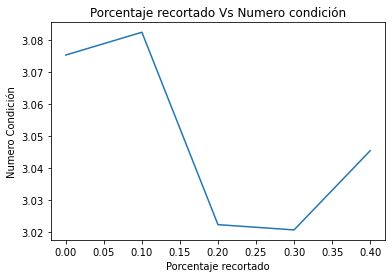

In [34]:
plt.title("Porcentaje recortado Vs Numero condición")
plt.ylabel("Numero Condición")
plt.xlabel("Porcentaje recortado")
plt.plot(contaminacionVec,numsCond)

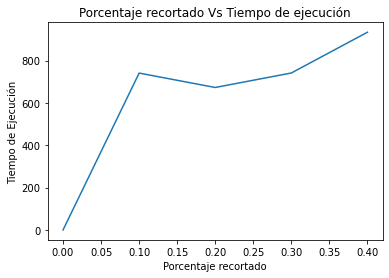

In [35]:
plt.title("Porcentaje recortado Vs Tiempo de ejecución")
plt.ylabel("Tiempo de Ejecución")
plt.xlabel("Porcentaje recortado")
plt.plot(contaminacionVec,tiemposRecorte)